# Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap
cmap1 = ListedColormap(['red', 'blue'])
cmap2 = ListedColormap(['orange', 'cyan'])
%matplotlib inline

## K-Means Clustering

### Vanilla implementation 

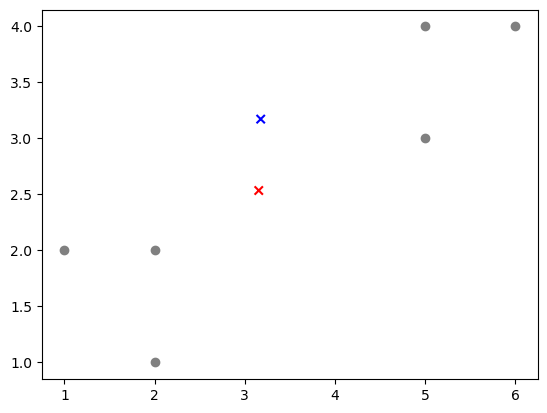

In [26]:
x = np.array([
    [1, 2],
    [2, 1],
    [2, 2],
    [5, 4],
    [5, 3],
    [6, 4],
])

# initial k means = 2 clusters
m = np.c_[
    x.mean(axis=0) + np.random.normal(0, x.std()/x.shape[0], size=2), 
    x.mean(axis=0) + np.random.normal(0, x.std()/x.shape[0], size=2)
].T

plt.scatter(x[:, 0], x[:, 1], c='gray')
plt.scatter(m[:, 0], m[:, 1], c=['r', 'b'], marker='x')

In [28]:
for _ in range(1): # 10 epochs

    # initialise labels (zero matrix with N rows and n_means columns)
    b = np.zeros((x.shape[0], m.shape[0]))

    for t, xt in enumerate(x):
        # compute euclidean distances from each xt to mi 
        dist = [np.linalg.norm(xt - mi) for mi in m]
        # take argmin i
        i = min(range(len(dist)), key=lambda x: dist[x])
        # update estimated labels
        b[t, i] = 1
            
    for i, mi in enumerate(m):
        # compute new estimates for means
        m[i] = np.sum((b[:, i, None] * x), axis=0) / np.sum(b[:, i])
b, m

(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]),
 array([[1.66666667, 1.66666667],
        [5.33333333, 3.66666667]]))

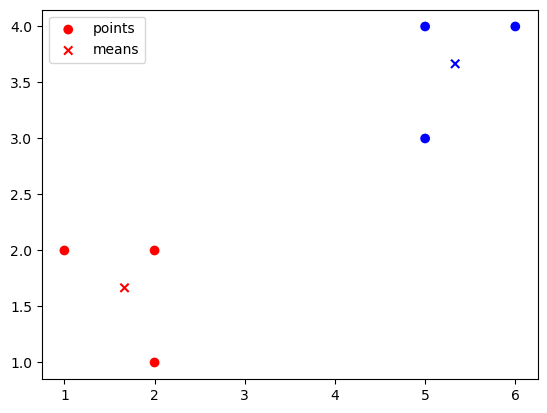

In [33]:
plt.scatter(x[:, 0], x[:, 1], c=b.argmax(axis=1), cmap=cmap1, label='points')
plt.scatter(m[:, 0], m[:, 1], c=['r', 'b'], marker='x', label='means')
plt.legend()

### Numpy intensive implementation

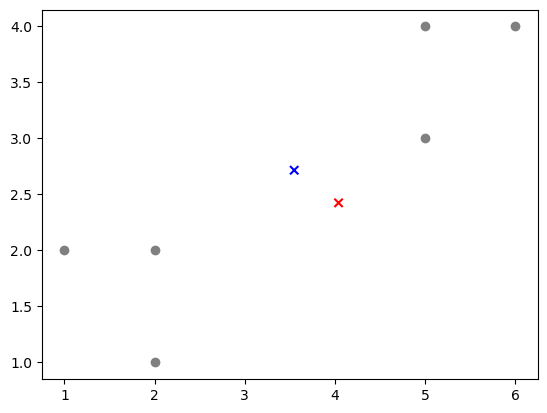

In [34]:
x = np.array([
    [1, 2],
    [2, 1],
    [2, 2],
    [5, 4],
    [5, 3],
    [6, 4],
])

# initial k means = 2 clusters
m = np.c_[
    x.mean(axis=0) + np.random.normal(0, x.std()/x.shape[0], size=2), 
    x.mean(axis=0) + np.random.normal(0, x.std()/x.shape[0], size=2)
].T

plt.scatter(x[:, 0], x[:, 1], c='gray')
plt.scatter(m[:, 0], m[:, 1], c=['r', 'b'], marker='x')

In [35]:
for _ in range(10): # 10 epochs

    mins = np.argmin(np.linalg.norm(x[..., None, :] - m, axis=2), axis=1)
    b = np.eye(mins.max() + 1)[mins]
    
    m = np.sum(b.T[..., None] * x, axis=1) / np.sum(b, axis=0)
b

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

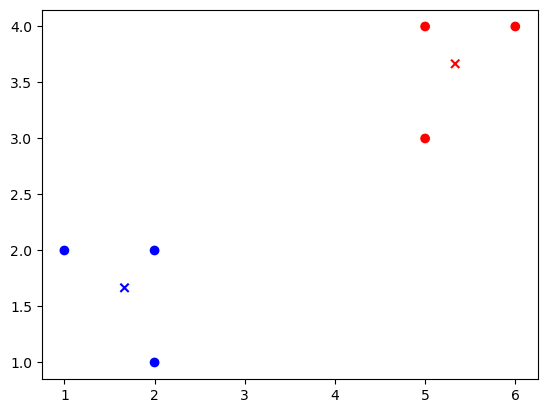

In [36]:
plt.scatter(x[:, 0], x[:, 1], c=b.argmax(axis=1), cmap=cmap1)
plt.scatter(m[:, 0], m[:, 1], c=['r', 'b'], marker='x')

### Class Encapsulation 

In [37]:
class KMeans:
    def __init__(self, n_means=2, max_iter=100) -> None:
        self.n_means = n_means
        self.max_iter = max_iter
        self.m = None # k-means (cluster centroids)
        self.loss_curve = None
    
    def fit(self, X: np.ndarray):
        X_mu = X.mean(axis=0)
        X_std = x.std()
        m = np.c_[
            [X_mu + np.random.normal(0, X_std/x.shape[0], size=X_mu.shape[0]) for _ in range(self.n_means)] 
        ]

        self.loss_curve = []

        for _ in range(self.max_iter):
            
            distances = np.linalg.norm(X[..., None, :] - m, axis=2)
            min_dist = np.argmin(distances, axis=1)
            b = np.eye(self.n_means)[min_dist]
            m = np.sum(b.T[..., None] * X, axis=1) / (np.sum(b, axis=0)[..., None]+1) # plus 1 to avoid divide by zero
            m[np.isnan(m)] = 0 # sometimes sum of b vec is zero which results in NaN 

            err = np.sum(b * distances**2)
            if len(self.loss_curve) > 0 and self.loss_curve[-1] == err:
                break
            
            self.loss_curve.append(err)
        
        self.m = m
        self.loss_curve = np.array(self.loss_curve)
        return self
    
    def predict(self, X: np.ndarray):
        distances = np.linalg.norm(X[..., None, :] - self.m, axis=2)
        min_dist = np.argmin(distances, axis=1)
        b = np.eye(self.n_means)[min_dist]
        return b.argmax(axis=1)
    
    # Does not work because cannot guarantee that mapping y -> y_pred is correct
    # If it does work, it is equavalent to the purity score
    # def score(self, X: np.ndarray, y: np.ndarray):
    #     y_pred = self.predict(X)
    #     # translate y labels to y_pred labels
    #     acc_dict = {yi : yi_pred for yi, yi_pred in zip(y, y_pred)}
    #     y_translated = np.vectorize(acc_dict.get)(y)
        
    #     return np.sum(y_translated == y_pred) / y.shape[0]
    
    # https://stats.stackexchange.com/questions/95731/how-to-calculate-purity
    def score(self, X: np.ndarray, y: np.ndarray):
        y_pred = self.predict(X)
        cm = np.zeros((self.n_means, self.n_means))

        for i in range(self.n_means):
            for j in range(self.n_means):
                cm[i, j] = np.sum((y_pred == i) & (y == j))

        return cm.max(axis=1).sum() / y.shape[0]

In [1166]:
kmeans = KMeans(n_means=2).fit(x)
kmeans.predict(x), kmeans.loss_curve

(array([0, 0, 0, 1, 1, 1], dtype=int64), array([20.53114063, 11.5625    ]))

#### Example 1: simple clustering of 3 clusters  

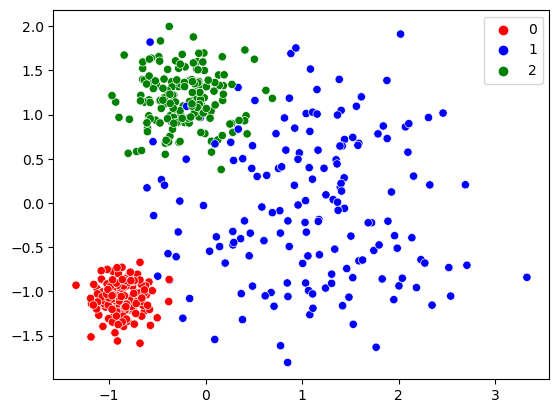

In [1215]:
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

cmap3 = ListedColormap(['red', 'blue', 'green'])

X, y = make_blobs(
    n_samples=500, 
    n_features=2,
    centers=[
        [-3, -4], 
        [8, 2], 
        [1, 9]
    ],
    cluster_std=[1, 5, 2]
)
X = (X - X.mean())/X.std()

xmin = X[:, 0].min(); xmax = X[:, 0].max()
ymin = X[:, 1].min(); ymax = X[:, 1].max()

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap3)

xx, yy = np.meshgrid(
    np.linspace(xmin-.5, xmax+.5, 100),
    np.linspace(ymin-.5, ymax+.5, 100)
)
D = np.vstack((xx.flatten(), yy.flatten())).T

(array([906.37572864, 203.27915041, 190.20717746, 188.99802581,
        188.92007012]),
 0.912)

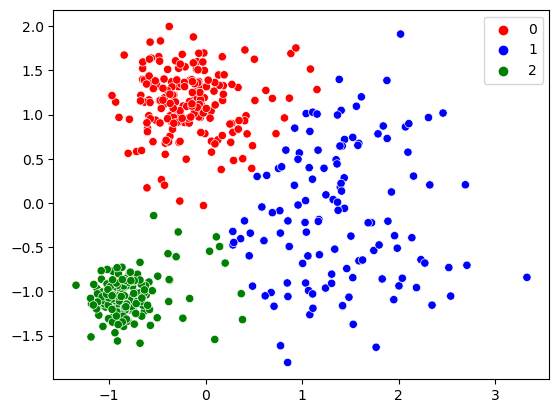

In [1217]:
kmeans = KMeans(n_means=3).fit(X)
y_pred = kmeans.predict(X)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_pred, palette=cmap3)
kmeans.loss_curve, kmeans.score(X, y)

array([730.13446788, 198.74343541, 196.58029158, 196.39389248,
       196.28076538, 196.22773565, 196.17125829, 196.14514559])

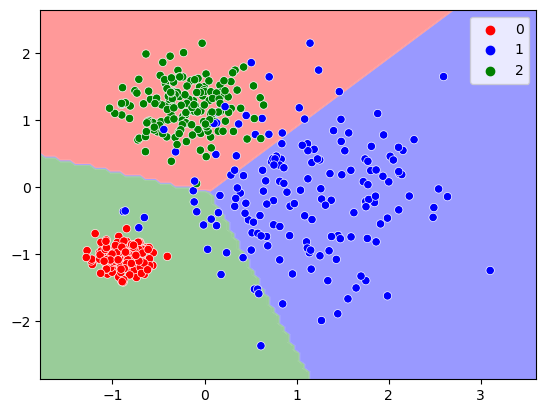

In [1148]:
kmeans = KMeans(n_means=3).fit(X)
y_pred = kmeans.predict(D)

plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=cmap3, alpha=0.4, antialiased=True)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap3)

kmeans.loss_curve

#### Example 2: clustering of image

(86904, 3)

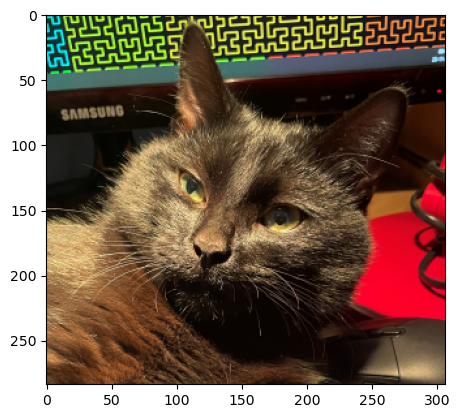

In [38]:
import imageio.v3 as iio

im = iio.imread("../datasets/kat.png")
im = im[:, :, :3].astype(np.uint32)

im_width = im.shape[0]
im_height = im.shape[1]

plt.imshow(im)

# im = im.reshape((im_height*im_width, 3))

# im = (im[:, 0] << 16) | \
#      (im[:, 1] << 8) | \
#      (im[:, 2] << 0)

# X = ((im[:, None] & (1 << np.arange(24))) > 0)*1
# X, X.shape

X = im.reshape((im_height*im_width, 3))
X.shape

In [42]:
kmeans = KMeans(n_means=8).fit(X)

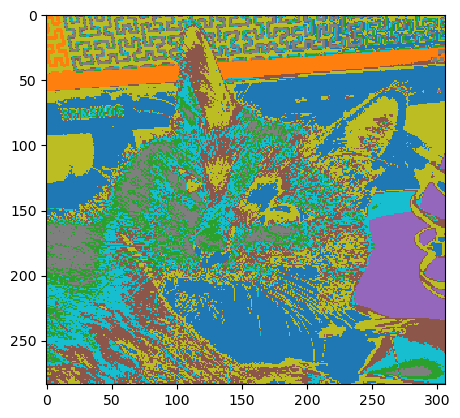

In [44]:
y_pred = kmeans.predict(X)
plt.imshow(y_pred.reshape((im_width, im_height)), interpolation='none', cmap='tab10')

In [45]:
y_pred.reshape((im_width, im_height))

array([[6, 6, 6, ..., 6, 0, 6],
       [1, 1, 1, ..., 6, 6, 0],
       [1, 1, 1, ..., 4, 4, 7],
       ...,
       [4, 4, 4, ..., 7, 7, 7],
       [4, 4, 4, ..., 7, 7, 7],
       [4, 4, 4, ..., 4, 4, 4]], dtype=int64)

#### Example 3: purity as function of k number of clusters 

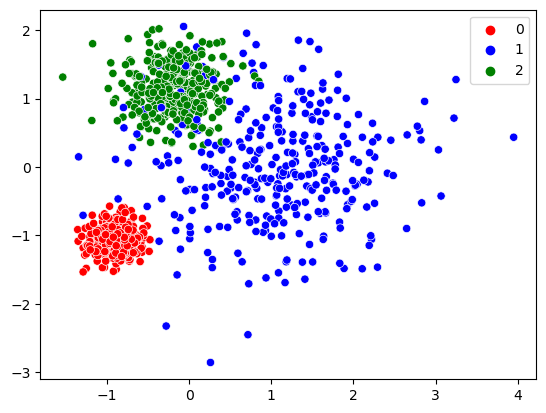

In [1222]:
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

cmap3 = ListedColormap(['red', 'blue', 'green'])

X, y = make_blobs(
    n_samples=1000, 
    n_features=2,
    centers=[
        [-3, -4], 
        [8, 2], 
        [1, 9]
    ],
    cluster_std=[1, 5, 2]
)
X = (X - X.mean())/X.std()

xmin = X[:, 0].min(); xmax = X[:, 0].max()
ymin = X[:, 1].min(); ymax = X[:, 1].max()

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap3)

xx, yy = np.meshgrid(
    np.linspace(xmin-.5, xmax+.5, 100),
    np.linspace(ymin-.5, ymax+.5, 100)
)
D = np.vstack((xx.flatten(), yy.flatten())).T

<AxesSubplot: >

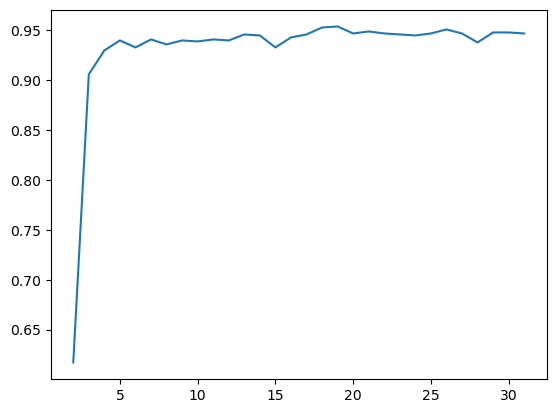

In [1226]:
purities = []

for k in range(2, 32):
    kmeans = KMeans(n_means=k).fit(X)
    purities.append(kmeans.score(X, y))

sns.lineplot(x=range(2, 32), y=purities)

### K-Means++ 

1. Choose initial center `m = np.array([x[j]])` uniformly from x
2. Choose next center by computing distance between every data point and every (already) chosen center
   
   `d2 = np.linalg.norm(x[..., None, :] - m, axis=2)`
   
   Gives `N x k` where `k` is current amount of centers
3. Minimise along rows 
   
   `d2_min = np.linalg.norm(x[..., None, :] - m, axis=2).min(axis=1)`
   
4. Create probability distribution and choose accordingly, 
   
   `d2_proba = d2 / d2.sum()`
   
   use index to find next center
   
5. Repeat until `K` centers are found 


In [1043]:
x = np.array([
    [1, 2],
    [2, 1],
    [2, 2],
    [5, 4],
    [5, 3],
    [6, 4],
])

array([[1, 2],
       [6, 4]])

In [1058]:
k = 3

j = np.random.randint(0, x.shape[0])
m = np.array([x[j]])

for _ in range(1, k):
    
    d2 = np.linalg.norm(x[..., None, :] - m, axis=2).min(axis=1)
    d2_proba = d2 / d2.sum()
    
    # print(d2_proba)
    i = np.random.choice(len(d2_proba), p=d2_proba.ravel())
    m = np.append(m, [x[i]], axis=0)
m

array([[1, 2],
       [2, 1],
       [5, 4]])

#### K-Means++ class implementation 

In [1218]:
from typing import Literal

class KMeans:
    def __init__(self, n_means=2, max_iter=100, init_scheme: Literal['kmeans++', 'random', 'total_mean']='kmeans++') -> None:
        self.n_means = n_means
        self.max_iter = max_iter
        self.m = None # k-means (cluster centroids)
        self.loss_curve = None
        self.init_scheme = init_scheme

    def init_centroids(self, X: np.ndarray):
        if self.init_scheme == 'total_mean':
            X_mu = X.mean(axis=0)
            X_std = x.std()
            m = np.c_[
                [X_mu + np.random.normal(0, X_std/x.shape[0], size=X_mu.shape[0]) for _ in range(self.n_means)] 
            ]
            return m
        elif self.init_scheme == 'random':
            idx = np.random.choice(range(X.shape[0]), size=self.n_means, replace=False)
            return np.copy(X[idx])
        elif self.init_scheme == 'kmeans++':
            j = np.random.randint(0, X.shape[0])
            m = np.array([X[j]])

            for _ in range(1, self.n_means):
                
                d2 = np.linalg.norm(X[..., None, :] - m, axis=2).min(axis=1)
                d2_proba = d2 / d2.sum()
                
                i = np.random.choice(len(d2_proba), p=d2_proba.ravel())
                m = np.append(m, [X[i]], axis=0)
            return m

    def fit(self, X: np.ndarray):
        X_mu = X.mean(axis=0)
        X_std = x.std()
        m = np.c_[
            [X_mu + np.random.normal(0, X_std/x.shape[0], size=X_mu.shape[0]) for _ in range(self.n_means)] 
        ]

        self.loss_curve = []

        for _ in range(self.max_iter):
            
            distances = np.linalg.norm(X[..., None, :] - m, axis=2)
            min_dist = np.argmin(distances, axis=1)
            b = np.eye(self.n_means)[min_dist]
            m = np.sum(b.T[..., None] * X, axis=1) / (np.sum(b, axis=0)[..., None]+1) # plus 1 to avoid divide by zero
            m[np.isnan(m)] = 0 # sometimes sum of b vec is zero which results in NaN 

            err = np.sum(b * distances**2)
            if len(self.loss_curve) > 0 and self.loss_curve[-1] == err:
                break
            
            self.loss_curve.append(err)
        
        self.m = m
        self.loss_curve = np.array(self.loss_curve)
        return self
    
    def predict(self, X: np.ndarray):
        distances = np.linalg.norm(X[..., None, :] - self.m, axis=2)
        min_dist = np.argmin(distances, axis=1)
        b = np.eye(self.n_means)[min_dist]
        return b.argmax(axis=1)
    
    # https://stats.stackexchange.com/questions/95731/how-to-calculate-purity
    def score(self, X: np.ndarray, y: np.ndarray):
        y_pred = self.predict(X)
        cm = np.zeros((self.n_means, self.n_means))

        for i in range(self.n_means):
            for j in range(self.n_means):
                cm[i, j] = np.sum((y_pred == i) & (y == j))

        return cm.max(axis=1).sum() / y.shape[0]

In [1219]:
x = np.array([
    [1, 2],
    [2, 1],
    [2, 2],
    [5, 4],
    [5, 3],
    [6, 4],
])

k1 = KMeans(n_means=3, init_scheme='kmeans++')
k2 = KMeans(n_means=3, init_scheme='random')
k3 = KMeans(n_means=3, init_scheme='total_mean')

k1.init_centroids(x), k2.init_centroids(x), k3.init_centroids(x), 

(array([[5, 4],
        [1, 2],
        [6, 4]]),
 array([[1, 2],
        [2, 1],
        [5, 4]]),
 array([[3.78007961, 2.77490748],
        [3.29944016, 2.69718449],
        [3.83227192, 2.458821  ]]))

#### Evaluation of init scheme

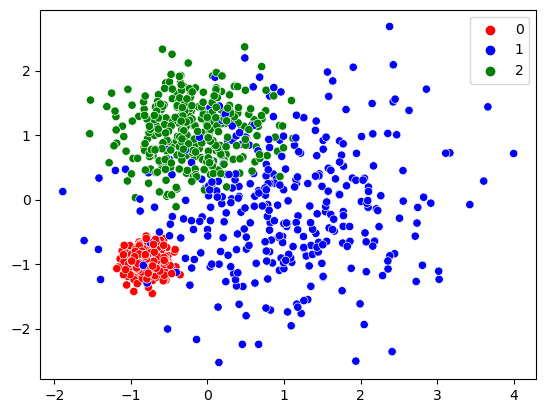

In [1271]:
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

cmap3 = ListedColormap(['red', 'blue', 'green'])

X, y = make_blobs(
    n_samples=1000, 
    n_features=2,
    centers=[
        [-3, -4], 
        [8, 2], 
        [1, 9]
    ],
    cluster_std=[1, 6, 3]
)
X = (X - X.mean())/X.std()

xmin = X[:, 0].min(); xmax = X[:, 0].max()
ymin = X[:, 1].min(); ymax = X[:, 1].max()

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap3)

xx, yy = np.meshgrid(
    np.linspace(xmin-.5, xmax+.5, 100),
    np.linspace(ymin-.5, ymax+.5, 100)
)
D = np.vstack((xx.flatten(), yy.flatten())).T

In [1272]:
n_repeated = 100

mean_scores = {}
wins = []

for init in ['kmeans++', 'random', 'total_mean']:
    
    purities = []
    for _ in range(n_repeated):
        kmeans = KMeans(n_means=3).fit(X)
        purities.append(kmeans.score(X, y))
    
    purities = np.array(purities)
    mean_scores[init] = purities.mean()
    wins.append(purities)

wins = np.array(wins).T
_, counts = np.unique(wins.argmax(axis=1), return_counts=True)
win_counts = {k: counts[i] for i, k in enumerate(mean_scores.keys())}

mean_scores, win_counts

({'kmeans++': 0.8610399999999998,
  'random': 0.8609899999999997,
  'total_mean': 0.8608199999999998},
 {'kmeans++': 66, 'random': 20, 'total_mean': 14})

## EM algorithm

In [2]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def add_ellipse(means, cov, color, ax):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    radius_x = np.sqrt(1+pearson)
    radius_y = np.sqrt(1-pearson)
    scale = np.sqrt(np.diag(cov)) * 3

    ellipse = Ellipse([0, 0], width=radius_x*2, height=radius_y*2, facecolor='none', edgecolor=color)
    transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale[0], scale[1]) \
            .translate(means[0], means[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

### Readable implementation

In [473]:
# https://stats.stackexchange.com/questions/95731/how-to-calculate-purity
def purity(y: np.ndarray, h: np.ndarray, n_components):
    y_pred = h.argmax(axis=1)
    cm = np.zeros((n_components, n_components))

    for i in range(n_components):
        for j in range(n_components):
            cm[i, j] = np.sum((y_pred == i) & (y == j))

    return cm.max(axis=1).sum() / y.shape[0]

0.952

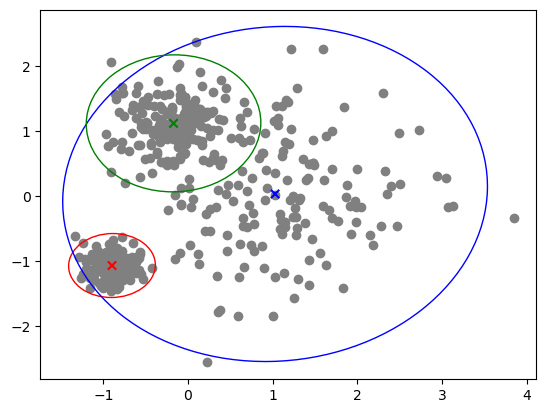

In [474]:
from sklearn.datasets import make_blobs

# Standard normal distribution
normal = lambda x, mu, cov: (1/((2*np.pi)**(cov.shape[0]/2) * np.linalg.det(cov)**0.5)) * np.exp(-0.5 * np.diag((x-mu) @ np.linalg.pinv(cov) @ (x-mu).T))

# input
x, y = make_blobs(
    n_samples=500, 
    n_features=2,
    centers=[
        [-3, -4], 
        [8, 2], 
        [1, 9]
    ],
    cluster_std=[1, 5, 2]
)
x = (x - x.mean())/x.std()

# priors over hidden vars (clusters)
priors = np.array([1/3]*3)

# initial means for clusters
m = x[np.random.choice(x.shape[0], size=3, replace=False)]

# initial covariances for clusters
Sigma = [np.random.random((x.shape[1], x.shape[1])) for _ in range(3)]
covs = np.array([0.5*(s + s.T)+5*np.eye(s.shape[0]) + np.random.random()*np.identity(s.shape[0]) for s in Sigma])

# iterate EM for 100 iters
for _ in range(100):
    # E-step
    ex = []
    for pi, mi, covi in zip(priors, m, covs):
        ex.append(pi*normal(x, mi, covi))
    ex = np.array(ex).T
    h = ex / ex.sum(axis=1, keepdims=True)

    # M-step
    # new priors
    priors = h.sum(axis=0) / x.shape[0]
    # new means
    m = []
    for hi in h.T:
        weighted_sum_h_x = 0
        for t, xt in enumerate(x):
            weighted_sum_h_x += hi[t] * xt
        m.append(weighted_sum_h_x / hi.sum())
    m = np.array(m)

    # new covariance matrices
    covs = []
    for mi, hi in zip(m, h.T):
        weighted_sum_h_xm = 0
        for t, xt in enumerate(x):
            weighted_sum_h_xm += hi[t] * (xt - mi)[..., None] @ (xt - mi)[..., None].T
        covs.append(weighted_sum_h_xm / hi.sum())
    covs = np.array(covs)

fig, ax = plt.subplots()
ax.scatter(x[:, 0], x[:, 1], c='gray')
ax.scatter(m[:, 0], m[:, 1], c=['r', 'b', 'g'], marker='x')
for mi, covi, col in zip(m, covs, ['r', 'b', 'g']):
    add_ellipse(mi, covi, col, ax)

purity(y, h, 3)

### Numpy intensive implementation

0.962

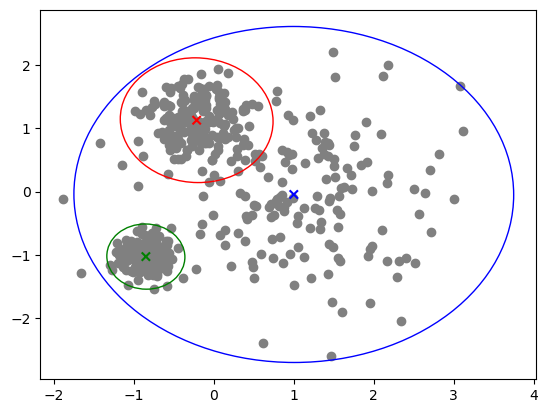

In [484]:
from sklearn.datasets import make_blobs

# Standard normal distribution
normal = lambda x, mu, cov: (1/((2*np.pi)**(cov.shape[0]/2) * np.linalg.det(cov)**0.5)) * np.exp(-0.5 * np.diag((x-mu) @ np.linalg.pinv(cov) @ (x-mu).T))

# input
x, y = make_blobs(
    n_samples=500, 
    n_features=2,
    centers=[
        [-3, -4], 
        [8, 2], 
        [1, 9]
    ],
    cluster_std=[1, 5, 2]
)
x = (x - x.mean())/x.std()

# priors over hidden vars (clusters)
priors = np.array([1/3]*3)

# initial means for clusters
m = x[np.random.choice(x.shape[0], size=3, replace=False)]

# initial covariances for clusters
Sigma = [np.random.random((x.shape[1], x.shape[1])) for _ in range(3)]
covs = np.array([0.5*(s + s.T)+5*np.eye(s.shape[0]) + np.random.random()*np.identity(s.shape[0]) for s in Sigma])

# iterate EM for 100 iters
for _ in range(100):
    # E-step
    expectation = np.array([pi*normal(x, mi, covi) for pi, mi, covi in zip(priors, m, covs)]).T
    h = expectation / expectation.sum(axis=1, keepdims=True)

    # M-step
    # new priors
    priors = h.sum(axis=0) / x.shape[0]
    # new means
    m = np.sum(h.T[..., None] * x, axis=1) / h.sum(axis=0)[..., None]
    # new covariance matrices
    covs = np.sum(h.T[..., None, None] * (x - m[..., None, :])[..., None] @ (x - m[..., None, :])[..., None, :], axis=1) / h.sum(axis=0)[..., None, None]

fig, ax = plt.subplots()
ax.scatter(x[:, 0], x[:, 1], c='gray')
ax.scatter(m[:, 0], m[:, 1], c=['r', 'b', 'g'], marker='x')
for mi, covi, col in zip(m, covs, ['r', 'b', 'g']):
    add_ellipse(mi, covi, col, ax)

purity(y, h, 3)

### EM-class

In [531]:
class EMOpt:
    def __init__(self, n_components=2, max_iter=100) -> None:
        self.n_components = n_components
        self.max_iter = max_iter
        self.params = None
        self.normal = lambda x, mu, cov: (1/((2*np.pi)**(cov.shape[0]/2) * np.linalg.det(cov)**0.5)) * np.exp(-0.5 * np.diag((x-mu) @ np.linalg.pinv(cov) @ (x-mu).T))

    def init_params(self, X: np.ndarray):
        self.params = {}
        # uninformative priors
        self.params['priors'] = np.array([1/self.n_components] * self.n_components)
        # randomly selected instances are initial means
        idx = np.random.choice(X.shape[0], size=self.n_components, replace=False)
        self.params['means'] = X[idx]
        # 
        Sigma = [np.random.random((X.shape[1], X.shape[1])) for _ in range(self.n_components)]
        covs = np.array([0.5*(s + s.T)+5*np.eye(s.shape[0]) + np.random.random()*np.identity(s.shape[0]) for s in Sigma])
        self.params['covs'] = covs

    def fit(self, X: np.ndarray):
        self.init_params(X)
        priors = self.params['priors']
        m = self.params['means']
        covs = self.params['covs']
        
        # begin iteration
        for _ in range(100):
            # E-step
            expectation = np.array([pi*normal(X, mi, covi) for pi, mi, covi in zip(priors, m, covs)]).T
            h = expectation / expectation.sum(axis=1, keepdims=True)

            # M-step
            # new priors
            priors = h.sum(axis=0) / X.shape[0]
            # new means
            m = np.sum(h.T[..., None] * X, axis=1) / h.sum(axis=0)[..., None]
            # new covariance matrices
            covs = np.sum(h.T[..., None, None] * (X - m[..., None, :])[..., None] @ (X - m[..., None, :])[..., None, :], axis=1) / h.sum(axis=0)[..., None, None]

        self.params['priors'] = priors
        self.params['means'] = m
        self.params['covs'] = covs

        return self
    
    def predict(self, X: np.ndarray):
        priors = self.params['priors']
        m = self.params['means']
        covs = self.params['covs']
        expectation = np.array([pi*self.normal(X, mi, covi) for pi, mi, covi in zip(priors, m, covs)]).T
        h = expectation / expectation.sum(axis=1, keepdims=True)
        return h
    
    # https://stats.stackexchange.com/questions/95731/how-to-calculate-purity
    def score(self, X: np.ndarray, y: np.ndarray):
        y_pred = self.predict(X).argmax(axis=1)
        cm = np.zeros((self.n_components, self.n_components))

        for i in range(self.n_components):
            for j in range(self.n_components):
                cm[i, j] = np.sum((y_pred == i) & (y == j))

        return cm.max(axis=1).sum() / y.shape[0]

### EM-Class example

0.962

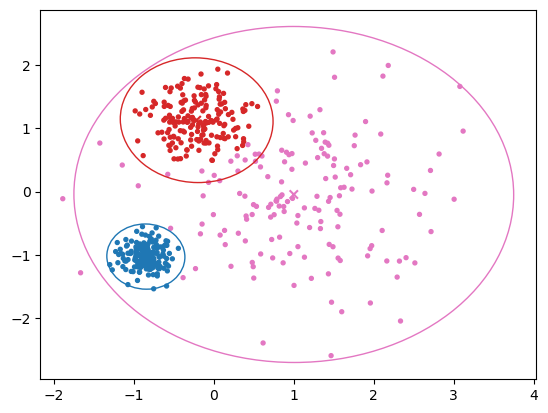

In [532]:
from matplotlib.colors import Normalize

k = 3

norm = Normalize(vmin=0, vmax=k, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.tab10)

em = EMOpt(n_components=k, max_iter=100).fit(x)

priors = em.params['priors']
m = em.params['means']
covs = em.params['covs']

y_pred = em.predict(x).argmax(axis=1)
m_pred = em.predict(m).argmax(axis=1)

fig, ax = plt.subplots()
ax.scatter(x[:, 0], x[:, 1], c=mapper.to_rgba(y_pred), s=8)
ax.scatter(m[:, 0], m[:, 1], c=mapper.to_rgba(m_pred), marker='x')

for mi, covi, col in zip(m, covs, mapper.to_rgba(m_pred)):
    add_ellipse(mi, covi, col, ax)

em.score(x, y)